In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
from functools import reduce

C:\Users\sanja\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#importing data
transaction = pd.read_excel("C:/Users/sanja/Desktop/my files/KPMG_VI_New_raw_data_update_final.xlsx", sheet_name='Transactions')
demo = pd.read_excel("C:/Users/sanja/Desktop/my files/KPMG_VI_New_raw_data_update_final.xlsx", sheet_name='CustomerDemographic')
Addr = pd.read_excel("C:/Users/sanja/Desktop/my files/KPMG_VI_New_raw_data_update_final.xlsx", sheet_name='CustomerAddress')

In [5]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [6]:
trn= transaction[transaction['order_status'] == 'Approved'] 

In [7]:
# RFM Analysis

In [8]:
PRESENT = dt.datetime(2021,5,25)
# Calculate the number of days between present date and date of last purchase,total profit and frequency of 
# purchases of each customer
rfm= trn.groupby('customer_id').agg({'transaction_date': lambda date: (PRESENT - date.max()).days,
                                        'product_id': lambda num: num.count(),
                                        'standard_cost': lambda price: price.sum()})

In [9]:
rfm.columns=['recency','frequency','monetary']

In [10]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [11]:
#converting to string for concatenation
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,1249,11,9084.45,1,1,1,111
2,1370,3,4149.07,4,4,4,444
3,1344,8,9888.23,4,1,1,411
4,1437,2,1047.72,4,4,4,444
5,1258,6,5903.20,1,3,3,133


In [12]:
#filtering customers whose score is 333 and above; giving equal importance for recency, frequency and monetory value when
#considering top customers
top_customers =rfm[rfm['RFM_Score']>='333'].sort_values('monetary', ascending=False)

In [13]:
scores = top_customers[[ 'RFM_Score']].copy()
scores.head()

,RFM_Score
customer_id,
1992,411
3212,411
34,411
1043,411
1093,411


In [14]:
merged_data = pd.merge(scores,demo,on='customer_id')
merged_data.head()

,customer_id,RFM_Score,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1992,411,Shanta,Attrill,Female,28,1995-10-21,Web Developer I,Manufacturing,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,3.0
1,3212,411,Corella,Bartomeu,Female,62,1981-01-15,Analog Circuit Design manager,Financial Services,Affluent Customer,N,ï¼ï¼ï¼,No,13.0
2,1043,411,Giorgi,Hurford,Male,34,1986-10-20,Sales Associate,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,16.0
3,1093,411,Clarita,Penright,Female,63,1996-09-13,Business Systems Development Analyst,NaN,Affluent Customer,N,00ËÆ$-,No,5.0
4,565,411,Saleem,Meller,Male,30,1959-10-02,Civil Engineer,Manufacturing,Mass Customer,N,00ËÆ$-,Yes,16.0


In [15]:
# Datafarme that contains demographic and geographic location of top customers
final_df = pd.merge(merged_data,Addr,on='customer_id')

In [16]:
final_df.isna().sum()

customer_id                              0
RFM_Score                                0
first_name                               0
last_name                               43
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     23
job_title                              158
job_industry_category                  207
wealth_segment                           0
deceased_indicator                       0
default                                 86
owns_car                                 0
tenure                                  23
address                                  0
postcode                                 0
state                                    0
country                                  0
property_valuation                       0
dtype: int64

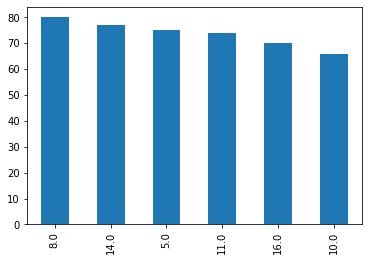

In [17]:
#Handling missing values
#Tenure
final_df.tenure.value_counts()[:10].plot(kind='bar')

In [18]:
avg= final_df['tenure'].mean()
final_df["tenure"].fillna(avg, inplace = True)

In [54]:
#Calculating Age from date of birth, filling missing values and creating bins
now = pd.Timestamp('now')
final_df['age'] = now - final_df['DOB']
final_df['age'] =final_df['age'].astype('timedelta64[Y]')

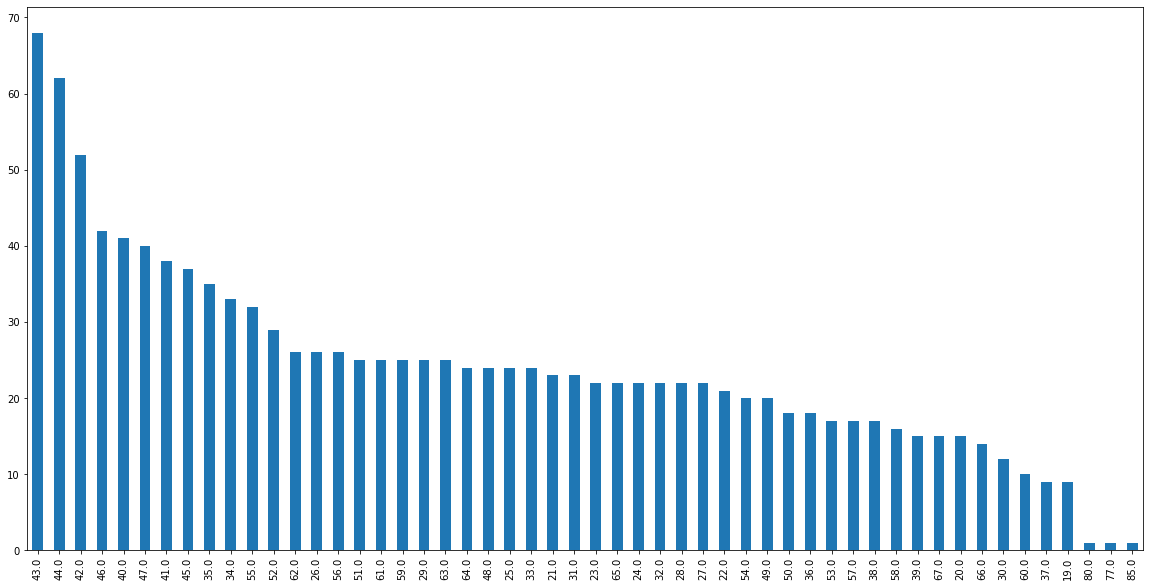

In [55]:
fig, ax = plt.subplots(figsize=(20,10))

final_df.age.value_counts().plot(kind='bar')

In [56]:
final_df['age_bins'] = pd.cut(x=final_df['age'], bins=[15, 25, 35, 45, 55, 67])

In [57]:
avg_age= final_df['age'].mean()
avg_age

43.23722044728434

In [58]:
final_df["age"].fillna(avg_age, inplace = True)

In [59]:
age=pd.get_dummies(final_df['age_bins'],columns='age_bins',prefix='age')

final_df=pd.concat([final_df, age], axis=1)


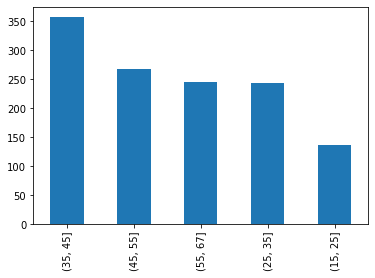

In [60]:
final_df.age_bins.value_counts().plot(kind='bar')

In [61]:
#one hot encoding - owns a car
oc=pd.get_dummies(final_df['owns_car'],columns='owns_car',prefix='owns_car')
final_df=pd.concat([final_df, oc], axis=1)

In [62]:
#one hot encoding - job category
job=pd.get_dummies(final_df['job_industry_category'],columns='job_industry_category',prefix='industry')
final_df=pd.concat([final_df, job], axis=1)

In [63]:
#one hot encoding - wealth_segment
ws=pd.get_dummies(final_df['wealth_segment'],columns='wealth_segment',prefix='wealth_segment')
final_df=pd.concat([final_df, ws], axis=1)


In [64]:
#gender
final_df = final_df.replace('Femal', 'Female')
final_df = final_df.replace('F', 'Female')
final_df = final_df.replace('Female', 'Female')
final_df = final_df.replace('Male', 'male')
final_df = final_df.replace('M', 'male')

In [65]:
final_df.gender.unique()

array(['Female', 'male', 'U'], dtype=object)

In [66]:
# one hot encoding -gender
gend=pd.get_dummies(final_df['gender'],columns='gender')
final_df=pd.concat([gend, final_df], axis=1)

In [67]:
#cleaning and one hot encoding -states
final_df['state'].unique()

array(['NSW', 'QLD', 'Victoria'], dtype=object)

In [68]:
final_df = final_df.replace("VIC", "Victoria")
final_df = final_df.replace("New South Wales", "NSW")

In [69]:
final_df['state'].unique()

array(['NSW', 'QLD', 'Victoria'], dtype=object)

In [70]:
state=pd.get_dummies(final_df['state'],columns='state')
final_df=pd.concat([final_df, state], axis=1)

In [71]:
#keeping only the nnecessary columns
df1 = final_df[['Female','male','past_3_years_bike_related_purchases',
          'wealth_segment_Affluent Customer', 'wealth_segment_High Net Worth', 'wealth_segment_Mass Customer', 'age_(15, 25]',
          'age_(25, 35]','age_(35, 45]','age_(45, 55]','age_(55, 67]',    
        'tenure', 'NSW','Victoria','QLD', 'industry_Argiculture', 
                  'industry_Entertainment','industry_Financial Services','industry_Health','industry_IT','industry_Manufacturing',
          'industry_Property','industry_Retail','industry_Telecommunications'
                  ]]

In [72]:
df1.head()

,Female,Female,male,male,past_3_years_bike_related_purchases,wealth_segment_Affluent Customer,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_High Net Worth,wealth_segment_Mass Customer,...,industry_IT,industry_IT,industry_Manufacturing,industry_Manufacturing,industry_Property,industry_Property,industry_Retail,industry_Retail,industry_Telecommunications,industry_Telecommunications
0,1,1,0,0,28,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
1,1,1,0,0,62,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,34,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,63,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,30,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
